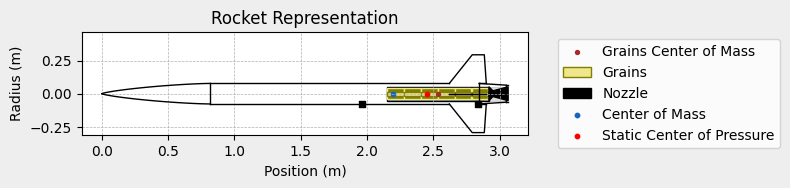

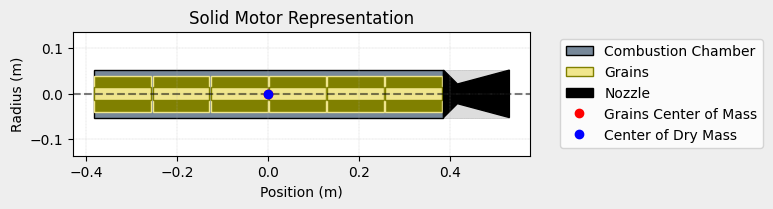

Nozzle Details
Nozzle Radius: 0.05224 m
Nozzle Throat Radius: 0.0216 m

Grain Details
Number of Grains: 6
Grain Spacing: 0.003175 m
Grain Density: 1474.8863164004988 kg/m3
Grain Outer Radius: 0.0403 m
Grain Inner Radius: 0.014605 m
Grain Height: 0.12488164 m
Grain Volume: 0.001 m3
Grain Mass: 0.816 kg

Motor Details
Total Burning Time: 3.611 s
Total Propellant Mass: 4.898 kg
Structural Mass Ratio: 0.532
Average Propellant Exhaust Velocity: 1822.391 m/s
Average Thrust: 2471.911 N
Maximum Thrust: 3663.200163515444 N at 0.635 s after ignition.
Total Impulse: 8926.072 Ns



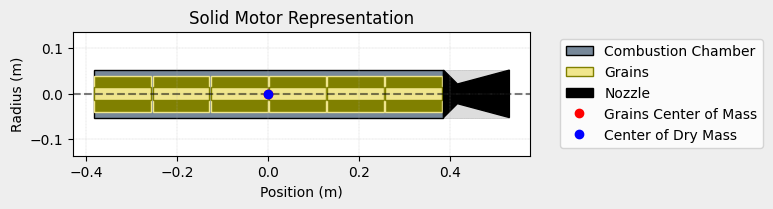

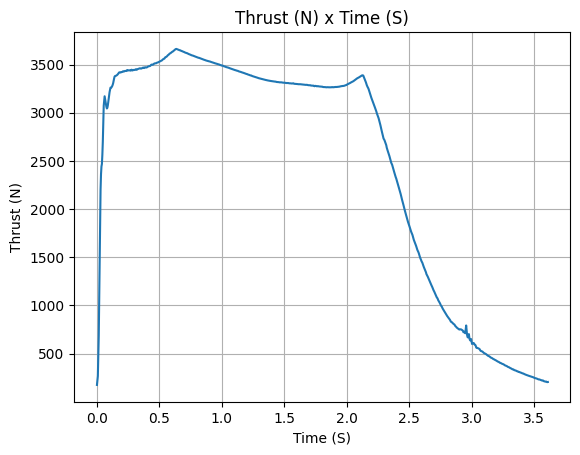

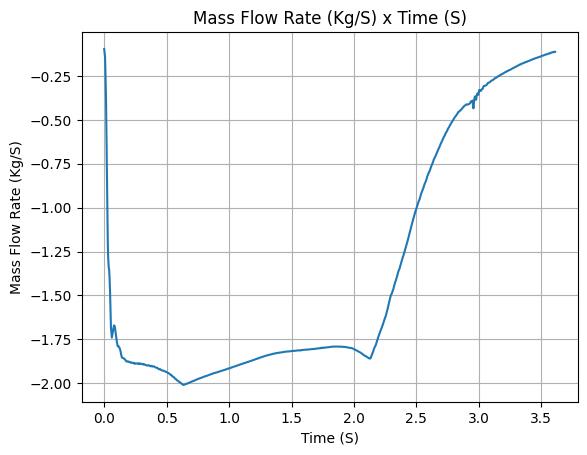

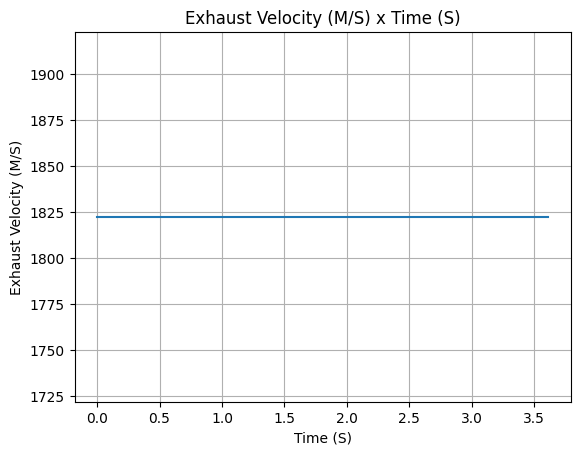

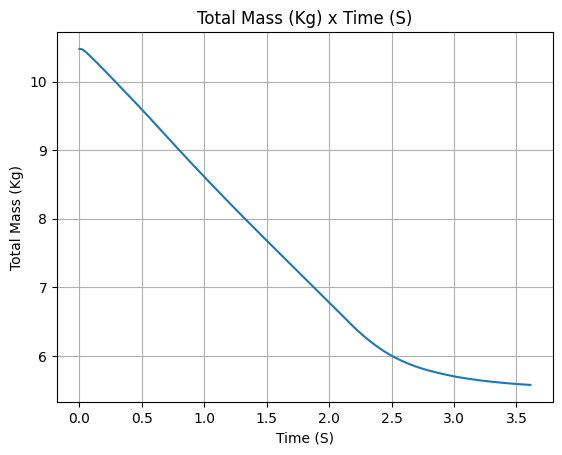

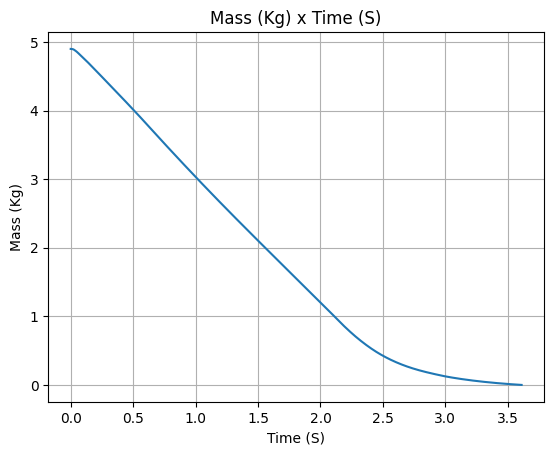

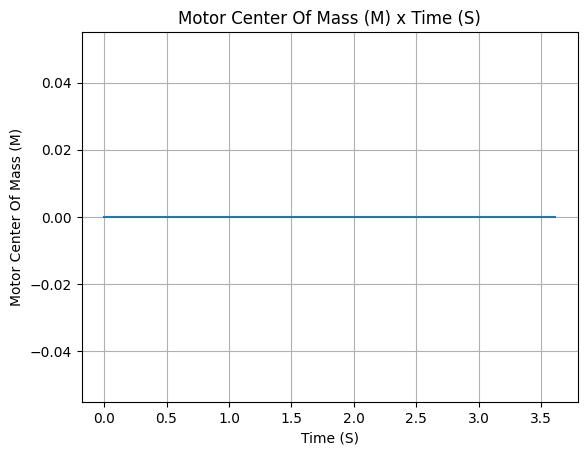

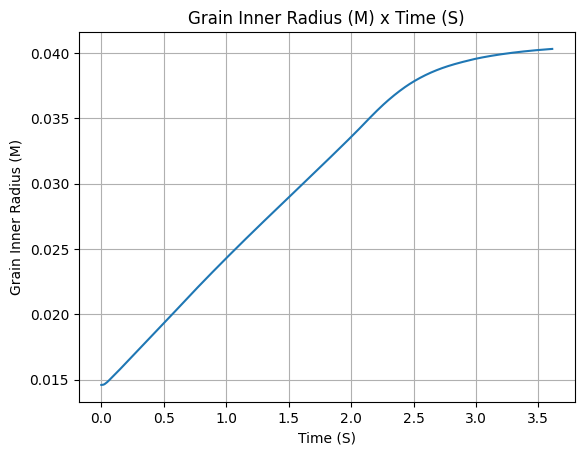

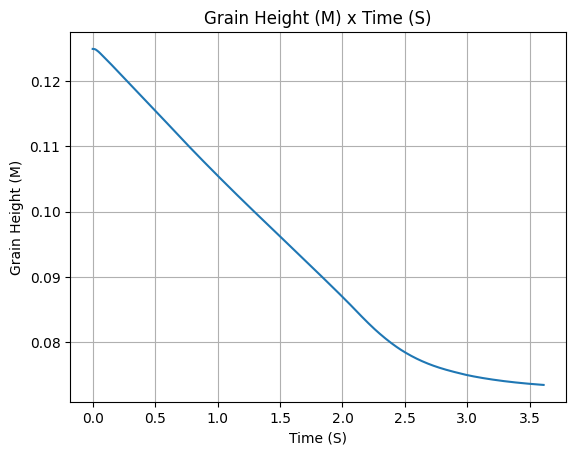

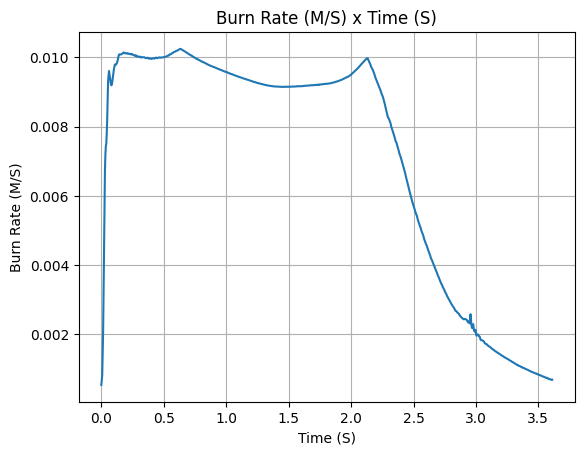

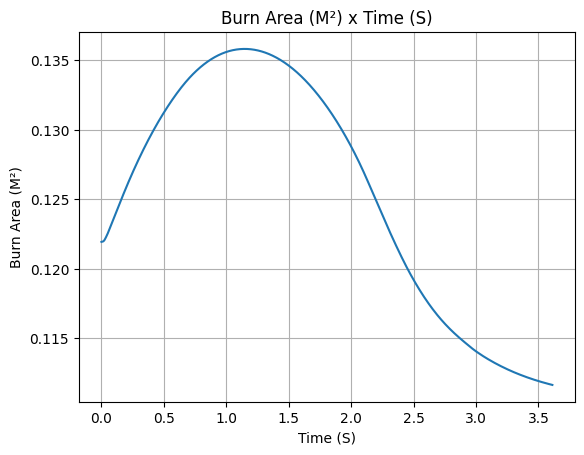

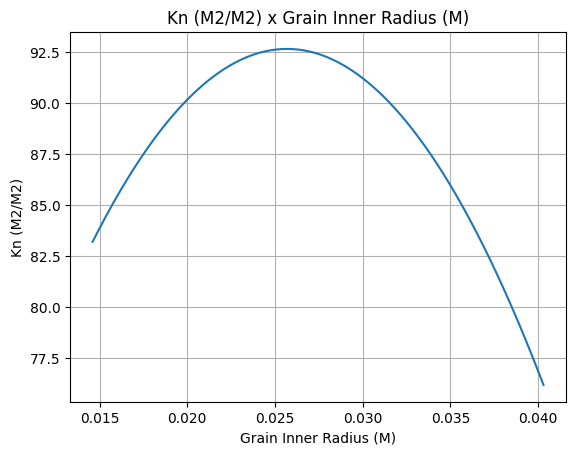

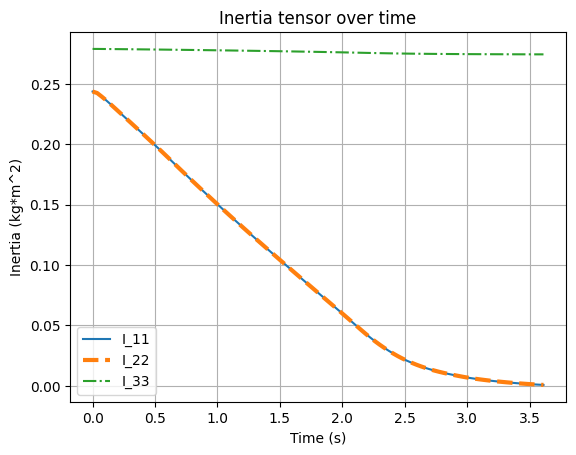

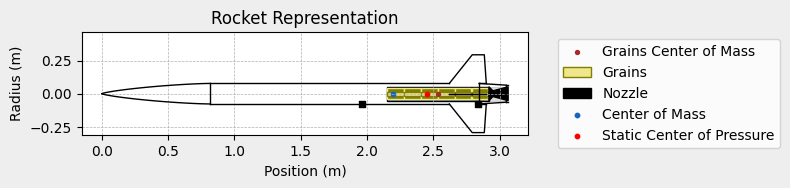


Inertia Details

Rocket Mass: 17.052 kg (without motor)
Rocket Dry Mass: 22.630 kg (with unloaded motor)
Rocket Loaded Mass: 27.528 kg
Rocket Structural Mass Ratio: 0.822
Rocket Inertia (with unloaded motor) 11: 7.144 kg*m2
Rocket Inertia (with unloaded motor) 22: 7.144 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.325 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.077343 m
Rocket Frontal Area: 0.018793 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.134 m
Rocket Center of Dry Mass - Nozzle Exit: 0.942 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.411 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.073 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 15.189/rad
Tail Lift Coefficient

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight
from numpy.random import normal, choice
from time import process_time
import numpy as np
from wind import makeWind

import FlightParams

import logging


import matplotlib.pyplot as plt
env = Environment(latitude = FlightParams.envParams["latitude"], longitude = FlightParams.envParams["longitude"], elevation = FlightParams.envParams["elevation"])

analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (FlightParams.spMass, 0), #.001
    # # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    # "rocket_inertia_11": (FlightParams.spCentralDiameter, 0.036),
    # # Rocket's inertia moment relative to its axis (kg*m^2)
    # "rocket_inertia_33": (FlightParams.spCentralAxis, 0.00001),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (FlightParams.dryMotorMass, 0), #.001
    # # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    # "motor_inertia_11": (FlightParams.motor_11_inertia, 0.016),
    # # Motors's dry inertia moment relative to its axis (kg*m^2)
    # "motor_inertia_33": (FlightParams.motor_33_inertia, 0.00001),\
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)
    # THIS is likely wrong, go back to check it

    "motor_dry_mass_position": (np.abs(FlightParams.the_motor_center_of_dry_mass_position - FlightParams.rocket_center_of_dry_mass_position), 0), #.001
    # Motor total impulse (N*s)
    "impulse": (FlightParams.impulse, 0), #25.3

    # "motor_position": (FlightParams.the_motor_position, .01),

    # Motor burn out time (s)
    # "burn_time": (FlightParams.burn_time, .3),
    # Motor's nozzle radius (m)
    "nozzle_radius": (FlightParams.the_nozzle_radius, 0), #.5 / 1000
    # Motor's nozzle throat radius (m)
    "throat_radius": (FlightParams.the_throat_radius, 0), #.5 / 1000
    # Motor's grain separation (axial distance between two grains) (m)
    # "grain_separation": (FlightParams.grainSeparation, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (FlightParams.motor_density, 0), #20
    # Motor's grain outer radius (m)
    # "grain_outer_radius": (FlightParams.grainOuterRadius, 0.3 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (FlightParams.grainInnerRadius, 0), #.3 / 1000
    # Motor's grain height (m)
    "grain_initial_height": (FlightParams.grainHeight, 0), #1 / 1000
    # Rocket's radius (kg*m^2)
    # "radius": (FlightParams.spRadius, 0.001),
    # Nozle position relative to motor
    # "nozzle_position": (FlightParams.the_nozzle_position, 0.001),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (FlightParams.rocket_center_of_dry_mass_position-(FlightParams.the_motor_center_of_dry_mass_position + FlightParams.the_motor_position), 0), #.0001
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    # "nose_distance_to_CM": (FlightParams.rocket_center_of_dry_mass_position-FlightParams.nose_cone_length, 0.001),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (FlightParams.inclination, 0), #1
    # Launch rail heading relative to north (degrees)
    "heading": (FlightParams.heading, 0), #2
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (FlightParams.drogueCdS, 0), #.02
    # Drag coefficient times reference area for the light chute
    "cd_s_light": (FlightParams.lightCdS, 0), #.02
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (FlightParams.lag_rec, 0), #.2
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (FlightParams.lag_se, 0), #.1
    # temperature in kelvin
    "temperature": (FlightParams.kelvin_temp, 0), #5
    # atmospheric pressure in pascals
    "atmosphere_pressure": (env.pressure_ISA(FlightParams.envParams["elevation"]), 0), #300

    #without motor
    "rocket_CM": (FlightParams.rocket_center_of_dry_mass_position, 0), #.01

    # adding these, but they don't vary
    "time_to_deploy_airbrake_after_burnout": (-1, 0),
    "fin_position": (2.62, 0)
}

def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] = normal(*parameter_value)
            else:
                flight_setting[parameter_key] = choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting["lag_rec"] < 0 or flight_setting["lag_se"] < 0:
            continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

def export_flight_data(flight_setting, flight_data, exec_time, env):
    # Generate flight results
    flight_result = {
        "out_of_rail_time": flight_data.out_of_rail_time,
        "out_of_rail_velocity": flight_data.out_of_rail_velocity,
        "max_velocity": flight_data.speed.max,
        "apogee_time": flight_data.apogee_time,
        "apogee_altitude": flight_data.apogee - env.elevation,
        "apogee_x": flight_data.apogee_x,
        "apogee_y": flight_data.apogee_y,
        "impact_x": flight_data.x_impact,
        "impact_y": flight_data.y_impact,
        "initial_static_margin": flight_data.rocket.static_margin(0),
        "out_of_rail_static_margin": flight_data.rocket.static_margin(
            flight_data.out_of_rail_time
        ),
        "out_of_rail_stability_margin": flight_data.out_of_rail_stability_margin,
        "execution_time": exec_time,
    }

    # Take care of parachute results
    return [flight_setting, flight_result]

def export_flight_error(flight_setting):
    print()
    return flight_setting

initial_cpu_time = process_time()

wind = makeWind(11, 10)

# Configure logging
logging.basicConfig(
filename='app.log',  # Change this to your desired log file
level=logging.INFO,
format='%(asctime)s - %(levelname)s - %(message)s',
filemode='a',  # 'w' for overwrite, 'a' for append
)
flightData = ["", "", ""]
env = Environment(latitude = FlightParams.envParams["latitude"], longitude = FlightParams.envParams["longitude"], elevation = FlightParams.envParams["elevation"])
i=0
for setting in flight_settings(analysis_parameters, 1):
    start_time = process_time()
    env.set_atmospheric_model(type=FlightParams.envParams["type"], pressure= setting["atmosphere_pressure"], temperature= setting["temperature"], wind_u = wind["u"], wind_v = wind["v"]) # Wind: (wind direction: 0 = North to South wind/90 = East to West wind, wind speed: m/s)
    # env.set_atmospheric_model(type=envParams["type"], pressure= setting["atmosphere_pressure"], temperature= setting["temperature"], wind_u= windArray_u(0,5), wind_v= windArray_v(0,5)) # Wind: (wind direction: 0 = North to South wind/90 = East to West wind, wind speed: m/s)
    MotorOne = SolidMotor(
        thrust_source="ReferencedFiles/" + FlightParams.motor_thrust_file, #Thrustcurve.org Mike Haberer - Rock Sim, Also uploaded to Google
        burn_time = FlightParams.burn_time,#Straight from thrustcurve.org
        reshape_thrust_curve=(FlightParams.burn_time, setting["impulse"]),
        nozzle_radius= setting["nozzle_radius"], # Part List
        throat_radius= setting["throat_radius"], # Part List
        grain_number=FlightParams.numGrains, #Based on cross-section
        grain_separation= FlightParams.grainSeparation, # Good
        grain_density= setting["grain_density"], #Calculated mass of grain / volume of grain , for this i did - the core since it should be empty? not sure
        grain_outer_radius= FlightParams.grainOuterRadius, # Good
        grain_initial_inner_radius= setting["grain_initial_inner_radius"], # Good
        grain_initial_height= setting["grain_initial_height"] , # Good
        interpolation_method = "linear",
        coordinate_system_orientation="combustion_chamber_to_nozzle",
        nozzle_position = FlightParams.the_nozzle_position,#eyeballed
        grains_center_of_mass_position= FlightParams.grain_center_of_mass_position,
        dry_mass=setting["motor_dry_mass"], #kg thrustcurve
        dry_inertia=(FlightParams.motor_11_inertia, FlightParams.motor_11_inertia, FlightParams.motor_33_inertia), #based off drawing
        center_of_dry_mass_position= FlightParams.center_of_dry_mass_within_motor,
    )

    #Pretty Much done except grain density and maybe nozz)le position

    Sp25 = Rocket(
        mass = setting["rocket_mass"], #OpenRocket
        radius = FlightParams.spRadius, #OpenRocket
        inertia = (FlightParams.spCentralDiameter, FlightParams.spCentralDiameter, FlightParams.spCentralAxis), # Calculated via Open Rocket
        coordinate_system_orientation = "nose_to_tail",
        center_of_mass_without_motor = setting["rocket_CM"], # OpenRocket
        power_off_drag ="ReferencedFiles/" + str(FlightParams.power_off_file), #Uploaded to drive
        power_on_drag = "ReferencedFiles/" + str(FlightParams.power_on_file), #Uploaded to drive
    )

    # CHANGE ONCE YOU FIND A GOOD WAY TO DO SO
    # Sp25.power_off_drag *= setting["power_off_drag"]
    # Sp25.power_on_drag *= setting["power_on_drag"]

    nose_cone = Sp25.add_nose(
        length = FlightParams.nose_cone_length, kind = FlightParams.nose_cone_type, position = FlightParams.nose_position)
    fin_set = Sp25.add_trapezoidal_fins(n=FlightParams.numFins, root_chord= FlightParams.root_chord, tip_chord=FlightParams.tip_chord, span=FlightParams.finSpan,
        position = setting["fin_position"],cant_angle=FlightParams.fin_cant_angle, sweep_length=FlightParams.fin_sweep_length)
    boattail = Sp25.add_tail(top_radius = FlightParams.spRadius, bottom_radius = FlightParams.boattail_bottom_radius,length = FlightParams.bottail_length,position = FlightParams.boattailPos)

    if(analysis_parameters["time_to_deploy_airbrake_after_burnout"] != -1):
        Sp25.add_air_brakes(
            drag_coefficient_curve= FlightParams.air_brake_drag_file,
            controller_function= FlightParams.airbrake_controller_function,
            sampling_rate= FlightParams.airbrake_sample_rate,
            reference_area = FlightParams.airbrake_area,
            clamp = FlightParams.airbrake_clamp,
            initial_observed_variables=[0, 0, 0],
            override_rocket_drag= FlightParams.override_rocketdrag_with_airbrakedrag,
            name = "Air brakes",
            airbrake_time = analysis_parameters["time_to_deploy_airbrake_after_burnout"]
        )

    Sp25.add_motor(MotorOne, FlightParams.the_motor_position)

    rail_buttons = Sp25.set_rail_buttons(
        upper_button_position= FlightParams.upper_railbutton_position,
        lower_button_position= FlightParams.lower_railbutton_position,
        angular_position=FlightParams.railbutton_angular_position
    )

    Drogue = Sp25.add_parachute(
        "Drogue",
        cd_s = analysis_parameters["cd_s_drogue"],
        trigger = FlightParams.drogueTrigger
    )
    Light = Sp25.add_parachute(
        "Light",
        cd_s = analysis_parameters["cd_s_light"],
        trigger = FlightParams.lightTrigger
    )

    Sp25.draw()
    plt.show()

    try:
        MotorOne.draw()
        MotorOne.all_info()

        Sp25.draw()
        Sp25.all_info()
        
        testFlight = Flight(
            rocket=Sp25, environment=env,rail_length = FlightParams.rail_length,inclination = analysis_parameters["inclination"],
            heading=analysis_parameters["heading"], terminate_on_apogee = False
        )
        inputOutput = export_flight_data(analysis_parameters, testFlight, process_time() - start_time, env)
        flightData[0] += "\n" + str(inputOutput[0])
        flightData[1] += "\n" + str(inputOutput[1])
    except Exception as E:
        flightData[2] += str(E) + "\n" + str(export_flight_error(analysis_parameters))
    # Register time
    i+=1
    if(i % 10 == 0):
        logging.getLogger().info(f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s")

